## Introduction and Dataset

The Stanford Sentiment Treebank(SST-2 Dataset | Papers With Code, no date), introduced in (Socher et al., 2013), is a dataset consisting of 11855 labelled reviews used for sentiment analysis. The dataset is derived from another by (Pang and Lee, 2005), the data was processed using the Stanford parser and then annotated by 3 people. SST-2 is the binary form of this dataset, SST-5 contains 5 labels with varying degrees of sentiment analysis. The SST-2 dataset has been chosen as it is utilised in the research paper discussed later. The dataset is almost perfectly balanced (displayed in graphs later in this section).

The task to be performed is sentiment analysis (or binary classification). The goal is to predict whether a given review parse tree is a positive or negative review. The labels are represented as Negative (0) or Positive (1).
The dataset is separated into three sets, the Training Set, Testing Set and Validation Set. The training set is used to fit models, the testing set is used for evaluating their results during the training process. The validation set is used in the evaluation stage and contains data that has been kept separate from the test and train data.


In [125]:
# TODO: Download GoogleNews 300 model and unzip it...
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import warnings

# Disable warnings
warnings.filterwarnings('ignore')

# Ensure consistency between runs
SEED = 1337
def reset_seed():
    random.seed(SEED)
    np.random.seed = SEED
    tf.random.set_seed(SEED)
reset_seed()
tf.config.experimental.enable_op_determinism()

# Train and Test are used for training/hyperparameter tuning
# Validation set is used exclusively for set validation and comparison

# Using the static split so that the results are comparable with the paper being referenced.
train_df = pd.read_table("data/train.tsv", header=None)
test_df = pd.read_table("data/test.tsv", header=None)
validation_df = pd.read_table("data/dev.tsv", header=None)

train_y = train_df[0].to_numpy()
train_x = train_df[1].to_numpy()

test_y = test_df[0].to_numpy()
test_x = test_df[1].to_numpy()

validation_y = validation_df[0].to_numpy()
validation_x = validation_df[1].to_numpy()

print(len(train_x))
print(len(test_x))
print(len(validation_x))

print('Example text and class:')
print(train_x[0])
print(train_y[0])

6920
1821
872
Example text and class:
a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films
1


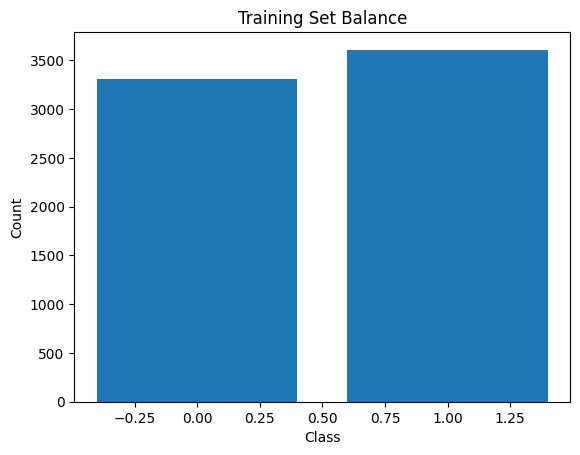

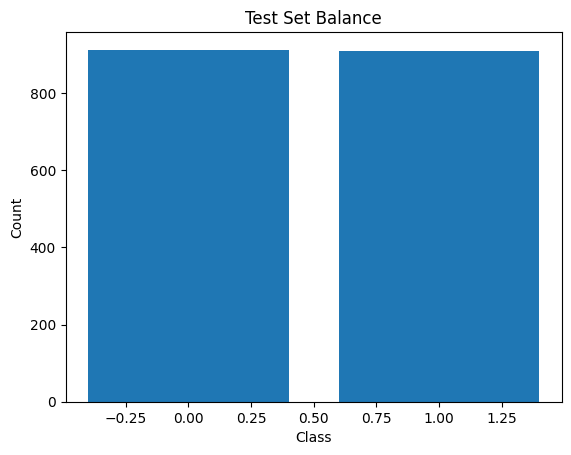

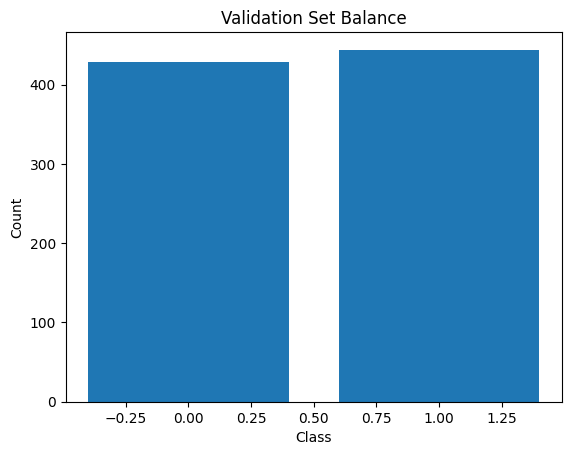

In [3]:
# Check dataset balance
import matplotlib.pyplot as plt

train_counts = train_df[0].value_counts()
plt.bar(train_counts.index, train_counts.values)
plt.title("Training Set Balance")
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

test_counts = test_df[0].value_counts()
plt.bar(test_counts.index, test_counts.values)
plt.title("Test Set Balance")
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

validation_counts = validation_df[0].value_counts()
plt.bar(validation_counts.index, validation_counts.values)
plt.title("Validation Set Balance")
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [4]:
import nltk

# Word tokenizer packages
nltk.download('punkt')
nltk.download('punkt_tab')

# WordNet lemmatizer
nltk.download('wordnet')

# Stopwords set
nltk.download('stopwords')

#https://medium.com/@maleeshadesilva21/preprocessing-steps-for-natural-language-processing-nlp-a-beginners-guide-d6d9bf7689c9
nltk.download('averaged_perceptron_tagger_eng')

from nltk.tokenize import word_tokenize #import the tokenize package
from nltk.corpus import wordnet

from nltk.stem import WordNetLemmatizer

# Based on stopwords.words("english")
all_stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves']

# Find most common words to add to stopwords set
token_counts = {}
for x in train_x:
    tokens = word_tokenize(x)
    for token in tokens:
        token_counts[token] = token_counts.get(token, 0) + 1

common_threshold = len(train_x) * 0.75
for token in token_counts:
    if token_counts[token] >= common_threshold:
        all_stopwords.append(token)

# Setup lemmatier
lemmatizer = WordNetLemmatizer()

# Part of Speech (POS) tagging conversion.
# Convert between the NLTK and WordNet representations for the lemmatizer stage
def posToWordnetPos(pos):
    #https://medium.com/@maleeshadesilva21/preprocessing-steps-for-natural-language-processing-nlp-a-beginners-guide-d6d9bf7689c9
    tag_mapping = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_mapping.get(pos[0].upper(), wordnet.NOUN)

# Tokenize sentence and "POS" tag tokens, strip stopwords, lemmatize words and recombine into "sentences"
def preprocess(X):
    prep_text = []
    for x in X:
        tokens = nltk.pos_tag(word_tokenize(x))
        tokens_stripped = [token for token in tokens if token[0] not in all_stopwords]
        tokens_lemmatized = [[lemmatizer.lemmatize(token[0], posToWordnetPos(token[1])) for token in tokens_stripped]]
        prep_text += tokens_lemmatized

    prep_sentences = [" ".join(sentence) for sentence in prep_text]
    return prep_sentences

pre_train_x = preprocess(train_x)
pre_test_x = preprocess(test_x)
pre_validation_x = preprocess(validation_x)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/reecemackie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/reecemackie/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/reecemackie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/reecemackie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/reecemackie/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [109]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

max_length = 0
for x in pre_train_x:
    max_length = max(max_length, len(word_tokenize(x)))

print('Max length in words from training set:')
print(max_length)

# Vectorization Constants
max_features = 15000
sequence_length = 50 # max sentence length (in words) is 47.

# Create a Keras vectorization layer to learn the vocabulary and create vector representations of sentences
# These will be passed into embedding layers for feature extraction
vectorize_layer = layers.TextVectorization(
    standardize=None, # Inputs are already pre-processed
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length,
)

vectorize_layer.adapt(pre_train_x)

def vectorize_text(text):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text)

# Vectorize all inputs up-front to avoid needing to do it again.
prep_train_x = vectorize_text(pre_train_x)
prep_test_x = vectorize_text(pre_test_x)
prep_validation_x = vectorize_text(pre_validation_x)

Max length in words from training set:
47


## Representation Learning

In [110]:
# Training a fresh embedding layer
from sklearn.metrics import accuracy_score, f1_score

# Reset random
reset_seed()

model = keras.Sequential([
    layers.Input((sequence_length,)),
    layers.Embedding(max_features, 128),
    layers.Bidirectional(layers.SimpleRNN(64, activation="relu")),
    layers.Dense(1, activation="sigmoid"),
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

print('Fitting Model')
model.fit(x=prep_train_x, y=train_y, epochs=10, batch_size=128)

pred = model.predict(prep_test_x)
predictions = (pred > 0.5).astype("int32")
f1 = f1_score(test_y, predictions)
print(f1)

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_29 (Embedding)        │ (None, 50, 128)        │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,944,833 (7.42 MB)

 Trainable params: 1,944,833 (7.42 MB)

 Non-trainable params: 0 (0.00 B)

Fitting Model
Epoch 1/10


2024-11-26 13:32:27.464094: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2024-11-26 13:32:27.464418: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5265 - loss: 0.6892
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7360 - loss: 0.5665
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9076 - loss: 0.2569
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9569 - loss: 0.1383
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9637 - loss: 0.1118
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9745 - loss: 0.0838
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9855 - loss: 0.0502
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9861 - loss: 0.0422
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9924 - loss: 0.0263
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9965 - loss: 0.0165
27/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

2024-11-26 13:32:35.325775: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-11-26 13:32:35.326048: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
0.7852998065764023


In [111]:
# Custom Trained Word2Vec + Fine-Tuning
from gensim.models import Word2Vec, KeyedVectors

# Reset random
reset_seed()

# Take the learned embeddings and remap them into the order as determined by the Text Vectorization layer being used
def gensim_to_keras_embedding(keyed_vectors: KeyedVectors, tokenizer: layers.TextVectorization, train_embeddings=False):
    vocab = tokenizer.get_vocabulary()
    vocab_size = len(vocab)
    embedding_dim = keyed_vectors.vector_size

    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    # Initializes unknown tokens with a normal distribution
    # This also covers TextVectorization's '[UNK]' for unrecognized tokens
    for i, word in enumerate(vocab):
        if word in keyed_vectors:
            embedding_matrix[i] = keyed_vectors[word]
        else:
            embedding_matrix[i] = np.random.normal(size=(embedding_dim,))

    # Construct the embedding layer, using the extracted weights
    return layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=train_embeddings,
    )

# Train W2V model on pre-processed training data
sentences = [word_tokenize(x) for x in pre_train_x]
w2v_model = Word2Vec(sentences=sentences, vector_size=300, window=5, min_count=1, workers=1, epochs=10)

w2v_embedding_layer = gensim_to_keras_embedding(w2v_model.wv, vectorize_layer, train_embeddings=True)

model = keras.Sequential([
    layers.Input((sequence_length,)),
    w2v_embedding_layer,
    layers.Bidirectional(layers.SimpleRNN(64, activation="relu")),
    layers.Dense(1, activation="sigmoid"),
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

print('Fitting Model')
model.fit(x=prep_train_x, y=train_y, epochs=10, batch_size=128)

pred = model.predict(prep_test_x)
predictions = (pred > 0.5).astype("int32")
f1 = f1_score(test_y, predictions)
print(f1)

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_30 (Embedding)        │ (None, 50, 300)        │     3,815,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        46,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,861,949 (14.73 MB)

 Trainable params: 3,861,949 (14.73 MB)

 Non-trainable params: 0 (0.00 B)

Fitting Model
Epoch 1/10


2024-11-26 13:32:42.560592: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2024-11-26 13:32:42.561090: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5440 - loss: 0.7029
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6376 - loss: 0.6383
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7723 - loss: 0.5158
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8950 - loss: 0.2977
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9469 - loss: 0.1603
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9642 - loss: 0.1084
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9925 - loss: 0.0332
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9958 - loss: 0.0248
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9969 - loss: 0.0145
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9983 - loss: 0.0106
41/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

2024-11-26 13:32:53.989447: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-11-26 13:32:53.989774: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
0.6232227488151659


In [112]:
# Google News 300 Word2Vec + Fine-Tuning

# Reset random
reset_seed()

google_w2v = KeyedVectors.load_word2vec_format("/Users/reecemackie/gensim-data/word2vec-google-news-300/word2vec-google-news-300", binary=True)
w2v_embedding_layer = gensim_to_keras_embedding(google_w2v, vectorize_layer, train_embeddings=True)

model = keras.Sequential([
    layers.Input((sequence_length,)),
    w2v_embedding_layer,
    layers.Bidirectional(layers.SimpleRNN(64, activation="relu")),
    layers.Dense(1, activation="sigmoid"),
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

print('Fitting Model')
model.fit(x=prep_train_x, y=train_y, epochs=10, batch_size=128)

pred = model.predict(prep_test_x)
predictions = (pred > 0.5).astype("int32")
f1 = f1_score(test_y, predictions)
print(f1)

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_31 (Embedding)        │ (None, 50, 300)        │     3,815,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        46,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,861,949 (14.73 MB)

 Trainable params: 3,861,949 (14.73 MB)

 Non-trainable params: 0 (0.00 B)

Fitting Model
Epoch 1/10


2024-11-26 13:33:09.210900: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2024-11-26 13:33:09.211330: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5226 - loss: 0.7311
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6520 - loss: 0.6369
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7433 - loss: 0.5399
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8541 - loss: 0.3545
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9196 - loss: 0.2276
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9489 - loss: 0.1562
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9738 - loss: 0.0850
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9831 - loss: 0.0646
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9707 - loss: 0.0899
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9353 - loss: 0.1611
44/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2024-11-26 13:33:19.958092: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-11-26 13:33:19.958398: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
0.6916010498687664


After pre-processing, the corpus has been processed to form a vocabulary and vectorized texts indexing this vocabulary, this representation will be used for learning.

Three different representation learning strategies have been attempted. The first was a plain Embedding layer trained alongside the rest of the model, the second was a Word2Vector trained on the training corpus and the final was fine-tuning the Google News Word2Vec model. The plain embedding layer performs the best, likely due to its ability to associate words directly with the class (good, bad, etc.), rather than for masked word predictions.

In spite of improved performance, the Google News fine-tuned model is selected, as this matches the paper I reimplement, and will mean my models can be fairly compared.

> Explain how Word2Vec is trained…

# Algorithms

## Bidirectional LSTM

TODO

## GRU

TODO

In [116]:
from keras_tuner import HyperParameters, RandomSearch

# Reset random
reset_seed()

def create_bi_lstm_model(hp: HyperParameters):
    model = keras.Sequential()
    model.add(layers.Input((sequence_length,)))
    model.add(gensim_to_keras_embedding(google_w2v, vectorize_layer, train_embeddings=True))

    if hp.Boolean("dropout"):
        model.add(layers.Dropout(0.5))

    model.add(layers.Bidirectional(
        layers.LSTM(
            units=hp.Int("units", min_value=32, max_value=384, step=32),
            activation="relu")))

    model.add(layers.Dense(1, activation="sigmoid"))

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model

tuner = RandomSearch(
    hypermodel=create_bi_lstm_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=2,
    #overwrite=True,
    directory="tuning",
    project_name="bilstm",
)

tuner.search_space_summary()

tuner.search(prep_train_x, train_y, epochs=2, validation_data=(prep_validation_x, validation_y))

models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Trial 5 Complete [00h 01m 07s]
val_accuracy: 0.7735091745853424

Best val_accuracy So Far: 0.7735091745853424
Total elapsed time: 00h 06m 09s


/Users/reecemackie/Projects/Rover656/CMM307-AdvancedAI/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 300)        │     3,815,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512)            │     1,140,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,956,349 (18.91 MB)

 Trainable params: 4,956,349 (18.91 MB)

 Non-trainable params: 0 (0.00 B)

In [114]:
# Reset random
reset_seed()

def create_gru_model(hp: HyperParameters):
    model = keras.Sequential()
    model.add(layers.Input((sequence_length,)))
    model.add(gensim_to_keras_embedding(google_w2v, vectorize_layer, train_embeddings=True))

    if hp.Boolean("emb-dropout"):
        model.add(layers.Dropout(0.5))

    model.add(layers.Bidirectional(
        layers.GRU(
            units=hp.Int("units", min_value=2, max_value=32, step=4),
            #activation="relu"
        )))

    if hp.Boolean("gru-dropout"):
        model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1, activation="sigmoid"))

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model

tuner = RandomSearch(
    hypermodel=create_gru_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=2,
    #overwrite=True,
    directory="tuning",
    project_name="gru",
)

tuner.search_space_summary()

tuner.search(prep_train_x, train_y, epochs=2, validation_data=(prep_validation_x, validation_y))

models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Trial 5 Complete [00h 00m 18s]
val_accuracy: 0.7981651425361633

Best val_accuracy So Far: 0.7981651425361633
Total elapsed time: 00h 01m 35s


/Users/reecemackie/Projects/Rover656/CMM307-AdvancedAI/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 300)        │     3,815,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 20)             │        18,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,833,841 (14.62 MB)

 Trainable params: 3,833,841 (14.62 MB)

 Non-trainable params: 0 (0.00 B)

# Evaluation

# Paper Overview

# Paper Implementation

In [124]:
# TODO: Implement the C-LSTM

from keras import regularizers, optimizers

# Reset random
reset_seed()

model = keras.Sequential([
    layers.Input((sequence_length,)),
    # Google Word2Vec embedding
    gensim_to_keras_embedding(google_w2v, vectorize_layer, train_embeddings=True),
    layers.Dropout(0.5),

    # Convolutional layer with 150 filters of size 3
    layers.Conv1D(150, kernel_size=3, activation="relu"),

    # ! Deviation - using MaxPooling1D, without this, model performs ~66%
    layers.MaxPooling1D(pool_size=2),

    # LSTM layer with 150 dimensionality
    layers.LSTM(150),
    layers.Dropout(0.5),

    # Softmax layer with L2 regularization
    layers.Dense(2, activation="softmax", kernel_regularizer=regularizers.L1L2(0, 0.001)),
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizers.RMSprop(), metrics=["accuracy"])
# model.compile(loss="binary_crossentropy", optimizer=optimizers.RMSprop(), metrics=["accuracy"])
# model.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(), metrics=["accuracy"])

model.summary()

print('Fitting Model')
model.fit(x=prep_train_x, y=train_y, validation_data=(prep_validation_x, validation_y), epochs=20)#, epochs=20, batch_size=128)

pred = model.predict(prep_test_x).argmax(axis=1)
predictions = (pred > 0.5).astype("int32")
f1 = f1_score(test_y, predictions)
print(f1)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 50, 300)        │     3,815,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 50, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 48, 150)        │       135,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 24, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,131,152 (15.76 MB)

 Trainable params: 4,131,152 (15.76 MB)

 Non-trainable params: 0 (0.00 B)

Fitting Model
Epoch 1/20


2024-11-26 14:41:54.314033: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2024-11-26 14:41:54.314336: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5060 - loss: 0.7538

2024-11-26 14:41:59.657841: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2024-11-26 14:41:59.658218: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5060 - loss: 0.7536 - val_accuracy: 0.5092 - val_loss: 0.6951
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5082 - loss: 0.6981 - val_accuracy: 0.6055 - val_loss: 0.6797
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5641 - loss: 0.6829 - val_accuracy: 0.6663 - val_loss: 0.6419
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6227 - loss: 0.6471 - val_accuracy: 0.7294 - val_loss: 0.5607
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6968 - loss: 0.5832 - val_accuracy: 0.7408 - val_loss: 0.5326
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7577 - loss: 0.5271 - val_accuracy: 0.7546 - val_loss: 0.4991
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7825 - loss: 0.4746 - val_accuracy: 0.7500 - val_loss: 0.5166
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8129 - loss: 0.4331 - val_accuracy: 0.784

2024-11-26 14:43:25.707858: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-11-26 14:43:25.708097: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
0.7823629169022046


# Evaluation

# References

Pang, B. and Lee, L. (2005) “Seeing Stars: Exploiting Class Relationships for Sentiment Categorization with Respect to Rating Scales,” Proceedings of the 43rd Annual Meeting on Association for Computational Linguistics  - ACL ’05, pp. 115–124. Available at: https://doi.org/10.3115/1219840.1219855.

Socher, R. et al. (2013) “Recursive Deep Models for Semantic Compositionality Over a Sentiment Treebank,” pp. 1631–1642. Available at: https://aclanthology.org/D13-1170 (Accessed: November 25, 2024).

SST-2 Dataset | Papers With Code (no date). Available at: https://paperswithcode.com/dataset/sst-2 (Accessed: November 25, 2024).

Zhou, C. et al. (2015) “A C-LSTM Neural Network for Text Classification.” Available at: https://arxiv.org/abs/1511.08630v2 (Accessed: November 25, 2024).
